# 📉 CPA Attack for RSA - Left-to-Right (Square then Multiply)

This Jupyter Notebook performs a **Correlation Power Analysis (CPA)** attack on a simulated RSA exponentiation. The attack targets the **Left-to-Right (LTR)** Square-then-Multiply algorithm to recover a secret key bit by bit.

The core principle is to correlate hypothetical power consumption with measured power traces. The power model used is the **Hamming Weight** of the intermediate results.
The attack is performed in a series of steps:
1.  **Configuration:** Define attack parameters like modulus, key length, and file paths.
2.  **Preprocessing:** Load and clean the power traces (baseline removal, filtering, alignment).
3.  **Hypothesis Generation:** For each key bit, generate two hypotheses (for a `0` and a `1` guess) for the intermediate computation values.
4.  **Correlation:** Compute the Pearson correlation between each hypothesis and the preprocessed traces.
5.  **Key Recovery:** The guess with the highest correlation peak is considered the correct key bit and is used for the next iteration.

This notebook will plot the correlation traces for each recovered bit to visually demonstrate the attack's success.

In [9]:
import os
import csv
import numpy as np
import matplotlib.pyplot as plt
from typing import Tuple

# Optional imports (graceful fallback)
try:
    from scipy.signal import butter, filtfilt, medfilt
    SCIPY_AVAILABLE = True
except Exception:
    SCIPY_AVAILABLE = False

# --- 1. CONFIGURATION ---
TRACE_FOLDER = "./"              # Folder containing your CSV
TRACE_FILENAME = "single_trace.csv"
RSA_N = 64507                    # Modulus used in your simulation
KEY_BITS = 15                    # Number of bits to recover
SPIKE_WIDTH = 500                # Width around detected spike to select window
verbose_plot = True              # True => show per-bit plots
BANDPASS_ON = False              # True => apply bandpass filter (if scipy available)
BP_LOW = 0.001
BP_HIGH = 0.4
BP_ORDER = 4

# --- 2. HELPERS ---
def hamming_weight(n: int) -> int:
    return bin(int(n) & 0xFFFFFFFFFFFFFFFF).count("1")

def load_traces(file_path: str) -> Tuple[np.ndarray, np.ndarray]:
    ciphertexts, traces = [], []
    with open(file_path, 'r') as f:
        reader = csv.reader(f)
        first = next(reader)
        # Heuristic to detect header
        try:
            int(first[0], 16)
            row0 = first
        except Exception:
            row0 = next(reader)
        ciphertexts.append(int(row0[0], 16))
        traces.append(np.array([float(x) for x in row0[1:]], dtype=np.float64))
        for row in reader:
            if not row:
                continue
            ciphertexts.append(int(row[0], 16))
            traces.append(np.array([float(x) for x in row[1:]], dtype=np.float64))
    return np.array(ciphertexts, dtype=np.int64), np.vstack(traces)

def baseline_remove(traces: np.ndarray, kernel_size: int = 51) -> np.ndarray:
    if SCIPY_AVAILABLE:
        k = kernel_size if kernel_size % 2 == 1 else kernel_size + 1
        out = np.empty_like(traces)
        for i in range(traces.shape[0]):
            out[i] = traces[i] - medfilt(traces[i], kernel_size=k)
        return out
    else:
        return traces - np.mean(traces, axis=1, keepdims=True)

def bandpass_filter(traces: np.ndarray, low: float, high: float, order: int = 4) -> np.ndarray:
    if not SCIPY_AVAILABLE:
        print("scipy not available: skipping bandpass filter.")
        return traces
    b, a = butter(order, [low, high], btype='band')
    filtered = np.empty_like(traces)
    for i in range(traces.shape[0]):
        filtered[i] = filtfilt(b, a, traces[i])
    return filtered

def detect_spike(traces: np.ndarray, width: int) -> Tuple[int, int, int]:
    avg_trace = np.mean(traces, axis=0)
    spike_index = int(np.argmax(np.abs(avg_trace - np.mean(avg_trace))))
    half = width // 2
    start = max(0, spike_index - half)
    end = min(traces.shape[1], spike_index + half)
    return start, end, spike_index

def align_traces(traces: np.ndarray, ref_index: int = 0, search_radius: int = 50,
                 spike_index: int = None) -> np.ndarray:
    n_traces, n_samples = traces.shape
    if spike_index is None:
        avg = np.mean(traces, axis=0)
        spike_index = int(np.argmax(np.abs(avg - np.mean(avg))))
    ref_trace = traces[ref_index]
    left = max(0, spike_index - search_radius)
    right = min(n_samples, spike_index + search_radius)
    ref_peak = int(np.argmax(np.abs(ref_trace[left:right])) + left)
    aligned = np.zeros_like(traces)
    for i in range(n_traces):
        tr = traces[i]
        left_i = max(0, spike_index - search_radius)
        right_i = min(n_samples, spike_index + search_radius)
        local_peak = int(np.argmax(np.abs(tr[left_i:right_i])) + left_i)
        shift = ref_peak - local_peak
        if shift == 0:
            aligned[i] = tr
        elif shift > 0:
            aligned[i, shift:] = tr[:n_samples - shift]
        else:
            s = -shift
            aligned[i, :n_samples - s] = tr[s:]
    return aligned

def compute_samplewise_correlation(hyp: np.ndarray, traces_window: np.ndarray) -> np.ndarray:
    hyp = hyp.astype(np.float64)
    N = hyp.shape[0]
    if N < 2:
        return np.zeros(traces_window.shape[1])
    hyp_mean = hyp.mean()
    hyp_std = hyp.std(ddof=0) + 1e-12
    hyp_norm = (hyp - hyp_mean) / hyp_std
    tw_mean = np.mean(traces_window, axis=0)
    tw_std = np.std(traces_window, axis=0) + 1e-12
    tw_norm = (traces_window - tw_mean) / tw_std
    return np.dot(hyp_norm, tw_norm) / float(N)

# --- 3. LTR hypothesis builder (square then multiply) ---
def build_hypothesis_for_guess_ltr(bit_index: int, guess: int, ciphertexts: np.ndarray,
                                   recovered_bits: list, rsa_n: int) -> np.ndarray:
    """
    Left-to-right (MSB-first) : square then multiply.
    recovered_bits is assumed to store bits in device order (0..bit_index-1).
    We simulate state AFTER processing the current bit (include square+possible multiply for current guess).
    """
    hyp = []
    for c in ciphertexts:
        S = 1
        for j in range(bit_index):
            S = (S * S) % rsa_n
            if recovered_bits[j] == '1':
                S = (S * c) % rsa_n
        # now process current bit (simulate the operation that produces leakage)
        S = (S * S) % rsa_n
        if guess == 1:
            S = (S * c) % rsa_n
        hyp.append(hamming_weight(S))
    return np.array(hyp, dtype=np.float64)

def run_cpa_ltr(ciphertexts: np.ndarray, trace_window: np.ndarray, rsa_n: int,
                key_bits: int, verbose_plot: bool = True):
    recovered_bits = []
    cumulative_peak = 0.0
    per_bit_peaks = []

    for bit_index in range(key_bits):
        best_guess = 0
        best_peak = -np.inf
        best_corr_vector = None

        # compute both guesses and compare absolute peak magnitudes
        guess_corrs = {}
        guess_peaks = {}
        for guess in (0, 1):
            hyp = build_hypothesis_for_guess_ltr(bit_index, guess, ciphertexts, recovered_bits, rsa_n)
            corr = compute_samplewise_correlation(hyp, trace_window)
            peak = float(np.max(np.abs(corr)))
            guess_corrs[guess] = corr
            guess_peaks[guess] = peak

            if peak > best_peak:
                best_peak = peak
                best_guess = guess
                best_corr_vector = corr.copy()

        recovered_bits.append(str(best_guess))
        cumulative_peak += best_peak
        per_bit_peaks.append(best_peak)

        # print per-guess peaks for clarity
        print(f"[ltr] Bit {bit_index + 1}/{key_bits} -> chosen={best_guess} (peak={best_peak:.6f})",
              f"  peaks: guess0={guess_peaks[0]:.6f}, guess1={guess_peaks[1]:.6f}")

        # plotting both guesses and marking their peaks
        if verbose_plot:
            plt.figure(figsize=(9, 2.8))
            colors = {0: "blue", 1: "red"}
            labels = {0: "guess=0", 1: "guess=1"}
            for guess in (0, 1):
                corr = guess_corrs[guess]
                peak_idx = int(np.argmax(np.abs(corr)))
                peak_val = corr[peak_idx]
                plt.plot(corr, color=colors[guess], alpha=0.6, label=f"{labels[guess]}")
                plt.plot(peak_idx, peak_val, "o", color=colors[guess], markersize=6,
                         label=f"{labels[guess]} peak={peak_val:.3f}")

            plt.title(f"ltr - Bit {bit_index + 1} chosen={best_guess}")
            plt.axvline(trace_window.shape[1] // 2, linestyle=":", color="gray", label="window center")
            plt.axhline(0, color="black", linestyle="--", linewidth=0.8)
            plt.xlabel("Window sample index")
            plt.ylabel("Pearson corr")
            plt.legend(loc="upper right")
            plt.tight_layout()
            plt.show()

    key_bin = "".join(recovered_bits)
    key_dec = int(key_bin, 2) if key_bin else None
    return {
        'convention': 'ltr',
        'key_bin': key_bin,
        'key_dec': key_dec,
        'cumulative_peak': cumulative_peak,
        'per_bit_peaks': per_bit_peaks
    }


--- Processing ./single_trace.csv ---
Loaded 300 traces, each with 800 samples.
Preprocessed traces shape (after baseline & alignment): (300, 800)
Spike window used for CPA: samples 0..265 (width 265)


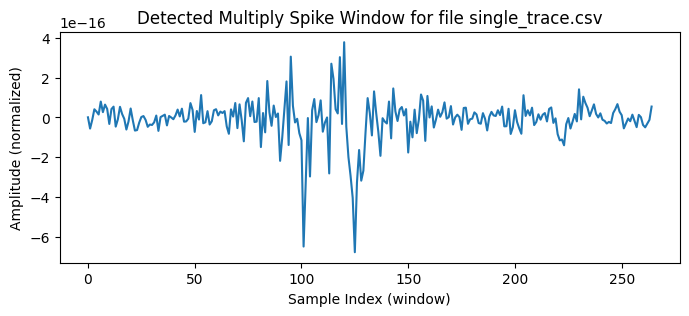

[ltr] Bit 1/15 -> chosen=1 (peak=0.313556)   peaks: guess0=0.000000, guess1=0.313556


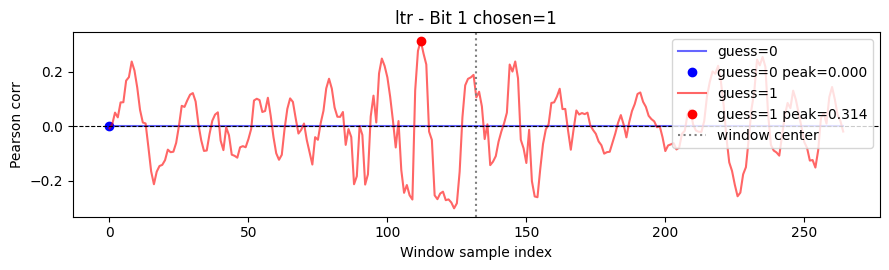

[ltr] Bit 2/15 -> chosen=1 (peak=0.186311)   peaks: guess0=0.151369, guess1=0.186311


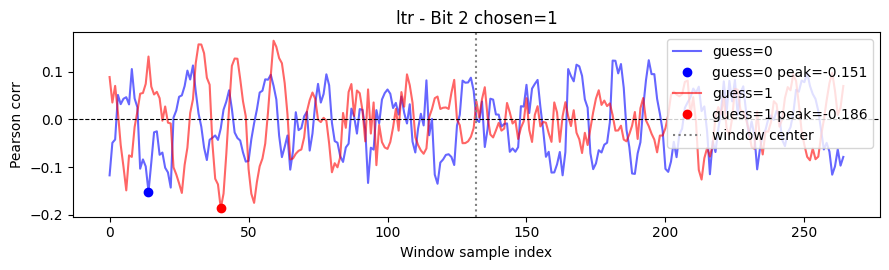

[ltr] Bit 3/15 -> chosen=0 (peak=0.168148)   peaks: guess0=0.168148, guess1=0.130334


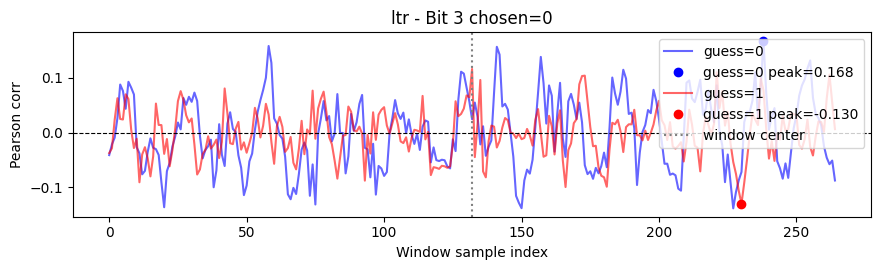

[ltr] Bit 4/15 -> chosen=0 (peak=0.151250)   peaks: guess0=0.151250, guess1=0.130774


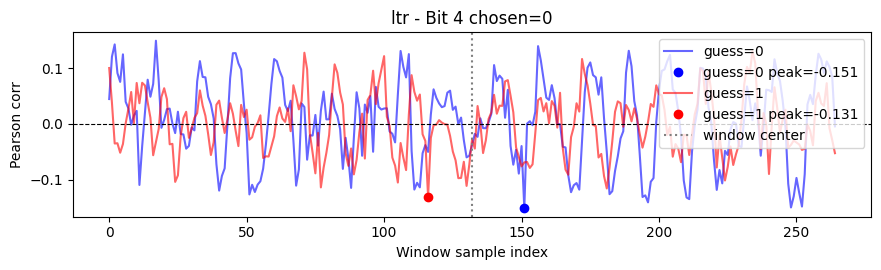

[ltr] Bit 5/15 -> chosen=1 (peak=0.243678)   peaks: guess0=0.195325, guess1=0.243678


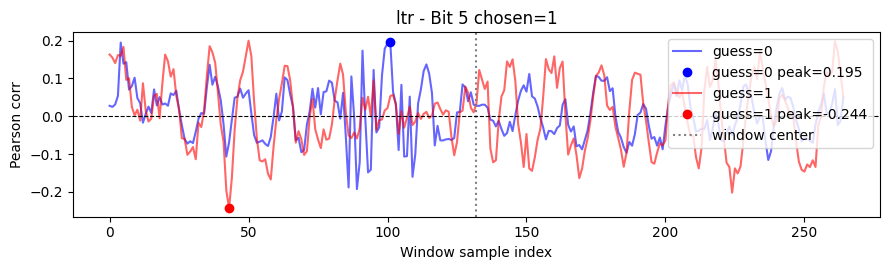

[ltr] Bit 6/15 -> chosen=1 (peak=0.222597)   peaks: guess0=0.213640, guess1=0.222597


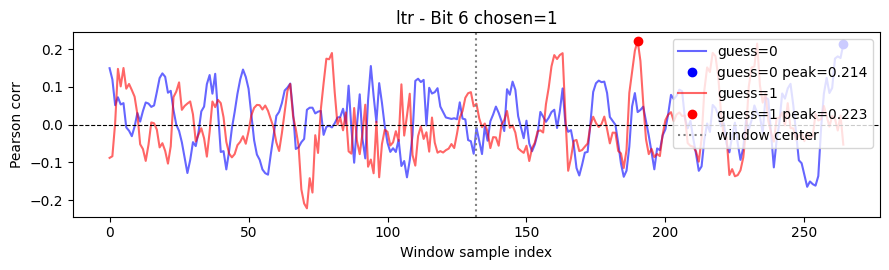

[ltr] Bit 7/15 -> chosen=0 (peak=0.305800)   peaks: guess0=0.305800, guess1=0.125461


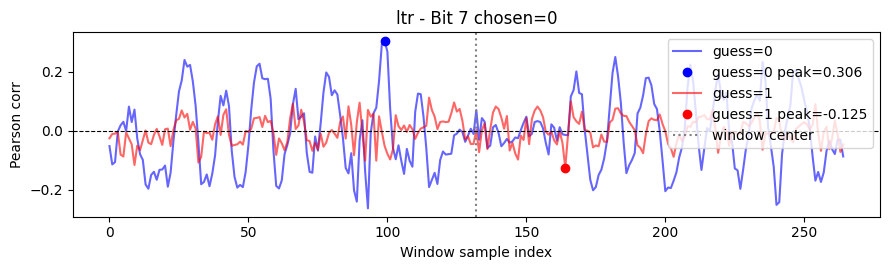

[ltr] Bit 8/15 -> chosen=1 (peak=0.324266)   peaks: guess0=0.156613, guess1=0.324266


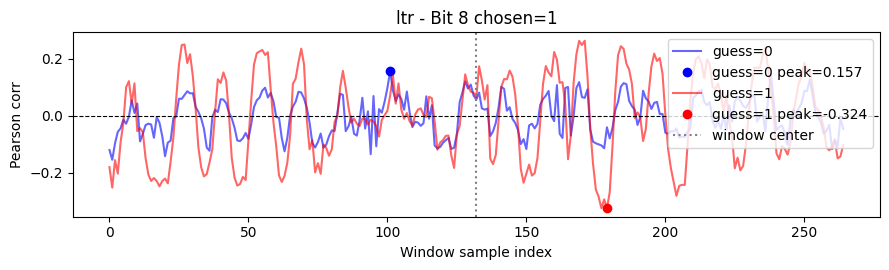

[ltr] Bit 9/15 -> chosen=1 (peak=0.202575)   peaks: guess0=0.165364, guess1=0.202575


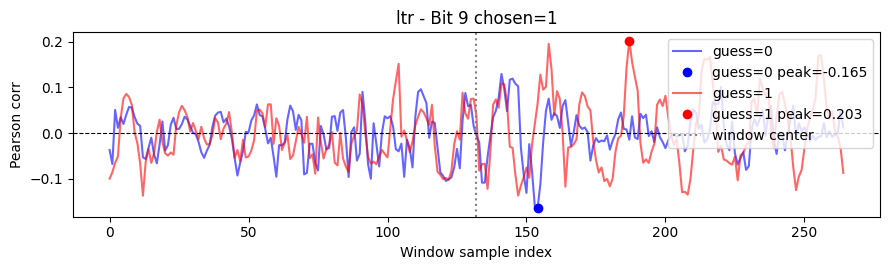

[ltr] Bit 10/15 -> chosen=1 (peak=0.172010)   peaks: guess0=0.158368, guess1=0.172010


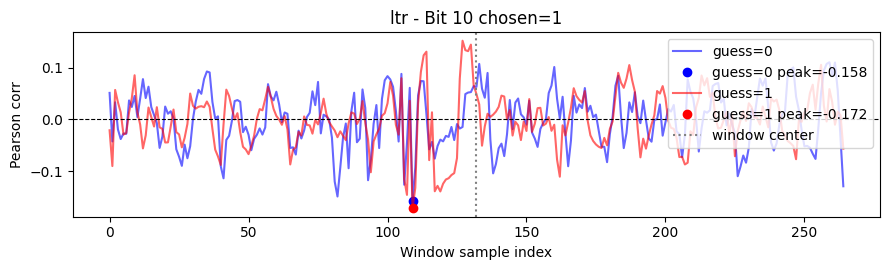

[ltr] Bit 11/15 -> chosen=1 (peak=0.173365)   peaks: guess0=0.143678, guess1=0.173365


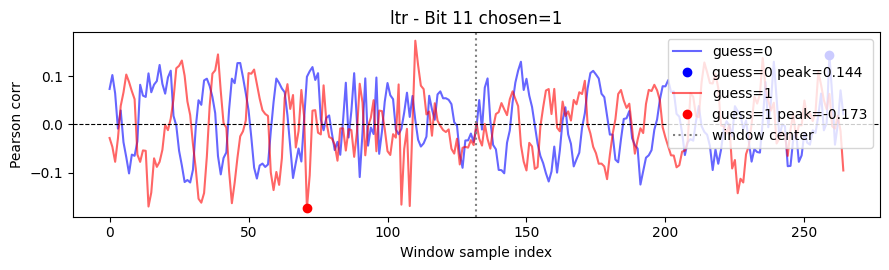

[ltr] Bit 12/15 -> chosen=0 (peak=0.154729)   peaks: guess0=0.154729, guess1=0.133610


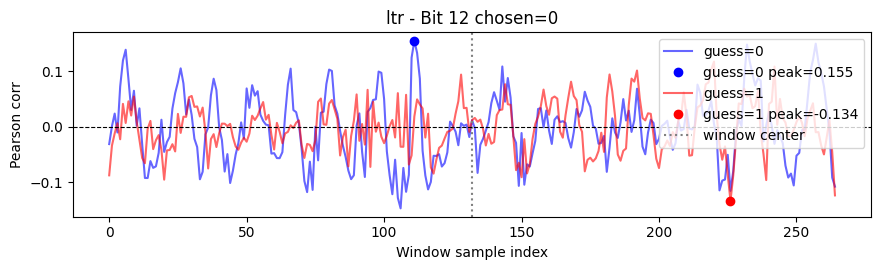

[ltr] Bit 13/15 -> chosen=0 (peak=0.148558)   peaks: guess0=0.148558, guess1=0.143090


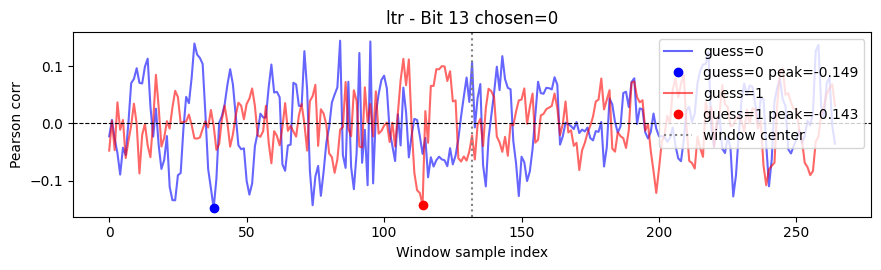

[ltr] Bit 14/15 -> chosen=0 (peak=0.148281)   peaks: guess0=0.148281, guess1=0.134174


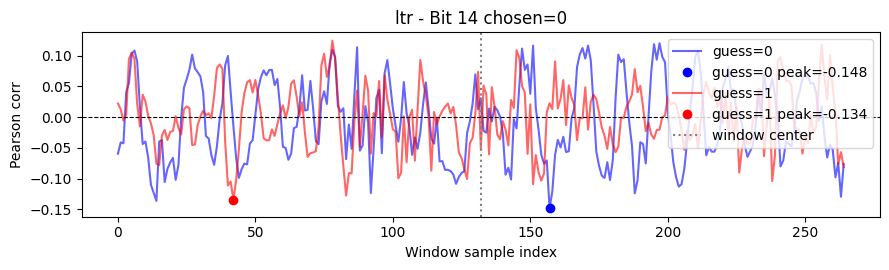

[ltr] Bit 15/15 -> chosen=0 (peak=0.167512)   peaks: guess0=0.167512, guess1=0.116332


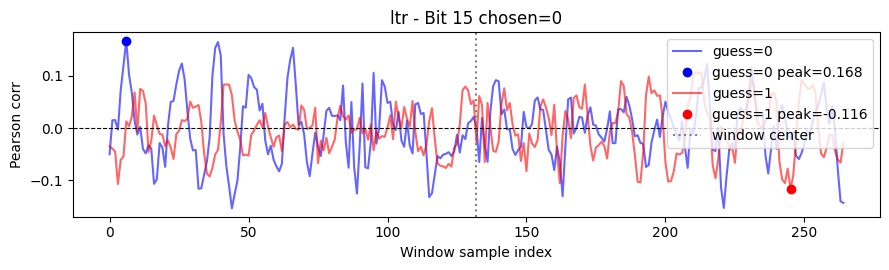


--- Summary ---
LTR cumulative peak sum: 3.082636, recovered key: 110011011110000 -> 26352
[+] Recovered key (binary): 110011011110000
[+] Recovered key (decimal): 26352


In [11]:
# --- 4. MAIN PROCESS ---
TRACE_FILE = os.path.join(TRACE_FOLDER, TRACE_FILENAME)
if not os.path.isfile(TRACE_FILE):
    raise FileNotFoundError(f"Trace file not found: {TRACE_FILE}")

print(f"\n--- Processing {TRACE_FILE} ---")
ciphertexts, traces = load_traces(TRACE_FILE)
num_traces, num_samples = traces.shape
print(f"Loaded {num_traces} traces, each with {num_samples} samples.")

if num_traces < 2:
    print("Too few traces for reliable CPA. Exiting.")
    # In a notebook, you can just return or use a less aggressive exit
    # to keep the environment alive for debugging.
    # exit(0)

# preprocessing
traces_br = baseline_remove(traces)
traces_f = bandpass_filter(traces_br, BP_LOW, BP_HIGH, BP_ORDER) if BANDPASS_ON else traces_br
start, end, spike_index = detect_spike(traces_f, SPIKE_WIDTH)
traces_aligned = align_traces(traces_f, ref_index=0, search_radius=200, spike_index=spike_index)
print('Preprocessed traces shape (after baseline & alignment):', traces_aligned.shape)

# normalize per-sample
sample_mean = np.mean(traces_aligned, axis=0)
sample_std = np.std(traces_aligned, axis=0) + 1e-12
traces_norm = (traces_aligned - sample_mean) / sample_std

# window selection
trace_window = traces_norm[:, start:end]
if trace_window.shape[1] <= 2:
    trace_window = traces_norm
print(f"Spike window used for CPA: samples {start}..{end} (width {trace_window.shape[1]})")

# Plotting the detected spike window
if verbose_plot:
    plt.figure(figsize=(8, 3))
    plt.plot(np.mean(trace_window, axis=0))
    plt.title(f"Detected Multiply Spike Window for file {TRACE_FILENAME}")
    plt.xlabel("Sample Index (window)")
    plt.ylabel("Amplitude (normalized)")
    plt.show()

# Run CPA (LTR only)
result_ltr = run_cpa_ltr(ciphertexts, trace_window, RSA_N, KEY_BITS, verbose_plot=verbose_plot)

print("\n--- Summary ---")
print(f"LTR cumulative peak sum: {result_ltr['cumulative_peak']:.6f}, recovered key: {result_ltr['key_bin']} -> {result_ltr['key_dec']}")
print(f"[+] Recovered key (binary): {result_ltr['key_bin']}")
print(f"[+] Recovered key (decimal): {result_ltr['key_dec']}")